# Project 1
- 2) Tìm hiểu bài toán phân loại văn bản đa nhãn Multi-label classification và các phương pháp giải quyết nó, tức là 1 input có thể thuộc về nhiều nhãn 

## Lib

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize

import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Snape\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Snape\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from wordcloud import WordCloud
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse as sp_sparse

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [5]:
from sklearn.metrics import roc_curve, auc
# from scipy import interp
from itertools import cycle

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

#for visualisation
import yellowbrick
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer

In [7]:
import numpy as np
import re
from pyvi import ViTokenizer

import pandas as pd

!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

In [8]:
import vncorenlp
from vncorenlp import VnCoreNLP

# Đường dẫn đến mô hình VnCoreNLP đã tải xuống
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx2g')

# Hàm tách từ
def word_tokenize(text):
    sentences = rdrsegmenter.tokenize(text)
    tokens = [token for sentence in sentences for token in sentence]
    return ' '.join(tokens)



## Functions

In [9]:
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
# Evaluation metric
import sys
import os
import os.path
from scipy.stats import sem
import numpy as np
from ast import literal_eval
import tensorflow as tf

def em_score(y_true, y_pred):
    MR = np.all(y_pred == y_true, axis=1).mean()
    return MR

def accuracy_score(y_true, y_pred):
    temp = 0
    for i in range(0, len(y_true)):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / len(y_true)


def f1_score(y_true, y_pred):
    temp = 0
    for i in range(len(y_true)):
        if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
            continue
        temp+= (2*sum(np.logical_and(y_true[i], y_pred[i]))) / (sum(y_true[i])+sum(y_pred[i]))
    return temp/ len(y_true)

In [11]:


vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

def make_label(data):
    lbl_job = []
    for td in data['job'].values:
        l_job_onehot = np.zeros(len(job_types))

        for i in range(0, len(job_types)):
            if job_types[i] in td:
                l_job_onehot[i] = 1
        lbl_job.append(l_job_onehot)

    return lbl_job


def return_label(y):
    lbl_job = []
    for i in range(0, len(y)):
        if y[i] == 1:
            lbl_job.append(job_types[i])

    return lbl_job

def custom_tokenizer(text_data, tokenizer='vncorenlp'):
    # text_data = text_data.lower()
    if tokenizer == 'vncorenlp':
        # return " ".join(vncorenlp.tokenize(str(text_data))[0])
        text = ""
        lst = vncorenlp.tokenize(str(text_data))
        for t in lst:
            text += " ".join(t)
        return text
    if tokenizer == 'none':
        return text_data
    return ViTokenizer.tokenize(str(text_data))

def pre_process(X, y):
    sentences = []

    for t in X:
        t = re.sub(r"[-()\"#/@;:<>{}`+=~|!?,]", "", t)
        sentences.append(custom_tokenizer(t, tokenizer='vncorenlp'))
    return (sentences, y)

## Read File

In [12]:
TRAIN = 'data/train.csv'
DEV = 'data/dev.csv'
TEST = 'data/test.csv'

LABEL = 'data/labels.csv'

train = pd.read_csv(TRAIN)
dev = pd.read_csv(DEV)
test = pd.read_csv(TEST)

label = pd.read_csv(LABEL)
job_types = label['job_type'].values

In [13]:
print(train.shape)
print(dev.shape)
print(test.shape)

(20234, 7)
(1760, 7)
(3933, 7)


In [14]:
job_types

array(['An Ninh / Bảo Vệ', 'An toàn lao động', 'Biên phiên dịch',
       'Bán hàng / Kinh doanh', 'Bán lẻ / Bán sỉ', 'Bưu chính viễn thông',
       'Bảo hiểm', 'Bảo trì / Sửa chữa', 'Bất động sản',
       'CNTT - Phần cứng / Mạng', 'CNTT - Phần mềm', 'Chăn nuôi / Thú y',
       'Chứng khoán', 'Công nghệ sinh học',
       'Công nghệ thực phẩm / Dinh dưỡng', 'Cơ khí / Ô tô / Tự động hóa',
       'Du lịch', 'Dược phẩm', 'Dầu khí',
       'Dệt may / Da giày / Thời trang', 'Dịch vụ khách hàng',
       'Giáo dục / Đào tạo', 'Giải trí',
       'Hàng gia dụng / Chăm sóc cá nhân', 'Hàng hải', 'Hàng không',
       'Hành chính / Thư ký', 'Hóa học', 'In ấn / Xuất bản', 'Khoáng sản',
       'Kiến trúc', 'Kế toán / Kiểm toán', 'Lao động phổ thông',
       'Luật / Pháp lý', 'Lâm Nghiệp', 'Môi trường',
       'Mới tốt nghiệp / Thực tập', 'Mỹ thuật / Nghệ thuật / Thiết kế',
       'Ngành khác', 'Ngân hàng', 'Nhà hàng / Khách sạn', 'Nhân sự',
       'Nông nghiệp', 'Nội ngoại thất', 'Phi chính phủ / Phi 

In [15]:
len(job_types)

68

## Overiview data


In [16]:
train['job_list'] = train['job'].str.strip("[]").str.replace("'", "").str.split(',')

train['job_list_length'] = train['job_list'].apply(len)

In [17]:
value_counts = train['job_list_length'].value_counts()

In [18]:
value_counts

job_list_length
1    10380
3     5248
2     4364
4      176
5       64
7        1
6        1
Name: count, dtype: int64

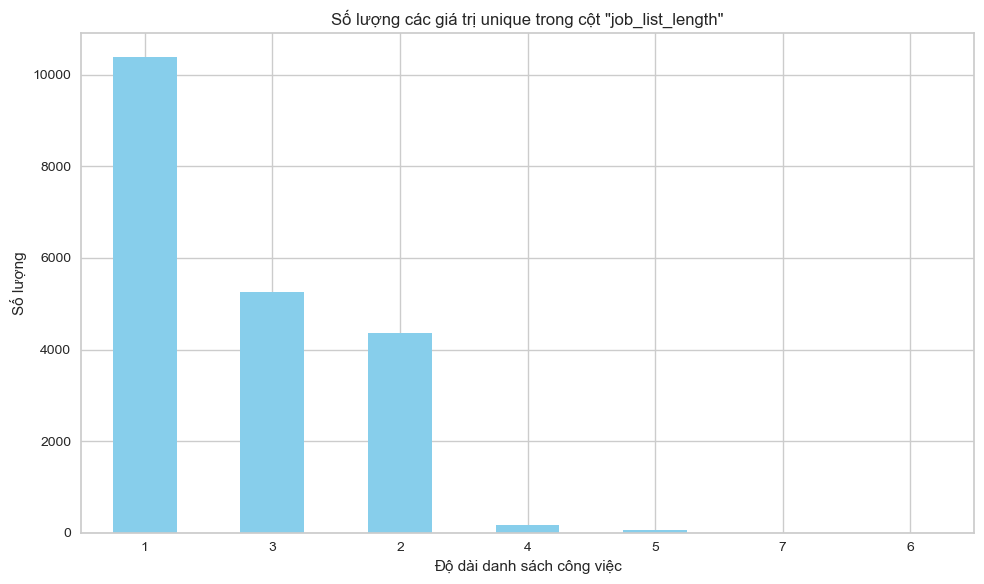

In [19]:
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Độ dài danh sách công việc')
plt.ylabel('Số lượng')
plt.title('Số lượng các giá trị unique trong cột "job_list_length"')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
job_counts = {}

# Duyệt qua mỗi danh sách công việc và đếm số lượng từng công việc
for jobs in train['job_list']:
    for job in jobs:
        if job in job_counts:
            job_counts[job] += 1
        else:
            job_counts[job] = 1

sorted_job_counts = dict(sorted(job_counts.items(), key=lambda x: x[1], reverse=True))

# Hiển thị kết quả sắp xếp
for job, count in sorted_job_counts.items():
    print(f"{job}: {count}")

CNTT - Phần mềm: 2611
 Bán hàng / Kinh doanh: 1715
Tư vấn: 1647
 Dịch vụ khách hàng: 1353
 Tiếp thị / Marketing: 1348
Giáo dục / Đào tạo: 1342
Kế toán / Kiểm toán: 1236
Nhân sự: 1080
Vận chuyển / Giao nhận / Kho vận: 1041
 Tài chính / Đầu tư: 968
 Sản xuất / Vận hành sản xuất: 942
 Kế toán / Kiểm toán: 903
 Tư vấn: 778
Mỹ thuật / Nghệ thuật / Thiết kế: 725
Xây dựng: 661
Quản lý điều hành: 631
 Điện / Điện tử / Điện lạnh: 625
 Quản lý chất lượng (QA/QC): 624
Bảo hiểm: 619
Hành chính / Thư ký: 607
 Thực phẩm & Đồ uống: 563
Quản lý chất lượng (QA/QC): 522
Bán lẻ / Bán sỉ: 522
Tiếp thị / Marketing: 503
Dịch vụ khách hàng: 477
 Dệt may / Da giày / Thời trang: 444
 CNTT - Phần cứng / Mạng: 441
 Nhà hàng / Khách sạn: 416
Cơ khí / Ô tô / Tự động hóa: 413
Bảo trì / Sửa chữa: 410
 Ngân hàng: 401
Bất động sản: 369
Xuất nhập khẩu: 346
Tài chính / Đầu tư: 344
Thu mua / Vật tư: 327
 Mỹ thuật / Nghệ thuật / Thiết kế: 318
Tiếp thị trực tuyến: 314
 Quảng cáo / Đối ngoại / Truyền Thông: 308
Bán hàng / K

In [58]:
len(sorted_job_counts)

122

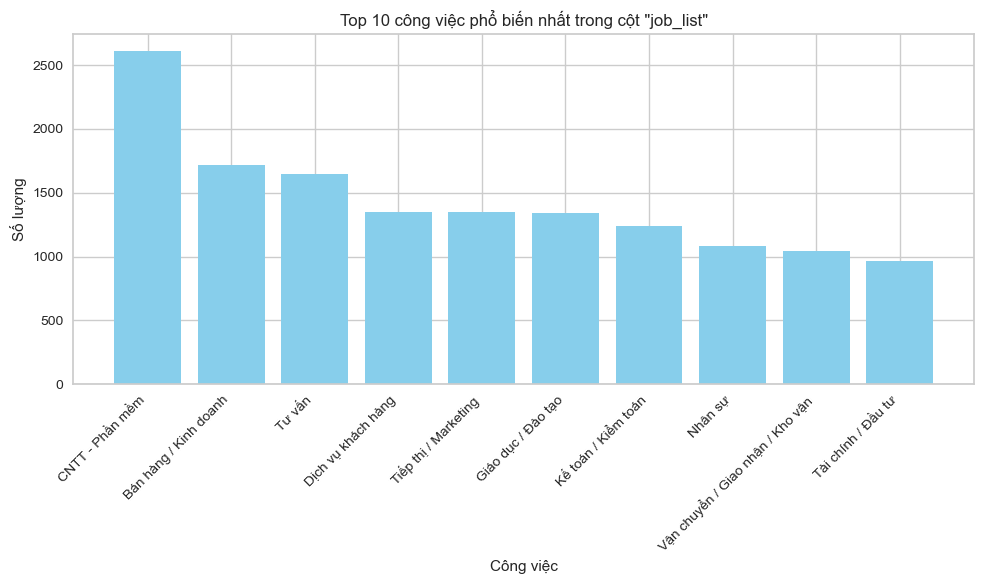

In [21]:
# Chuyển dictionary thành DataFrame để dễ xử lý và hiển thị
job_counts_df = pd.DataFrame(list(job_counts.items()), columns=['Job', 'Count'])

# Sắp xếp DataFrame theo số lượng giảm dần
job_counts_df = job_counts_df.sort_values(by='Count', ascending=False)

# Chọn ra top 10 công việc phổ biến nhất
top_10_jobs = job_counts_df.head(10)

# Trực quan hóa số lượng của top 10 công việc bằng biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(top_10_jobs['Job'], top_10_jobs['Count'], color='skyblue')
plt.xlabel('Công việc')
plt.ylabel('Số lượng')
plt.title('Top 10 công việc phổ biến nhất trong cột "job_list"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [22]:
dev['job_list'] = dev['job'].str.strip("[]").str.replace("'", "").str.split(',')

dev['job_list_length'] = dev['job_list'].apply(len)

In [23]:
# X = pd.concat([, dev['job_description']])

In [24]:
value_counts_dev = dev['job_list_length'].value_counts()

In [25]:
value_counts_dev

job_list_length
1    734
3    559
2    406
4     39
5     22
Name: count, dtype: int64

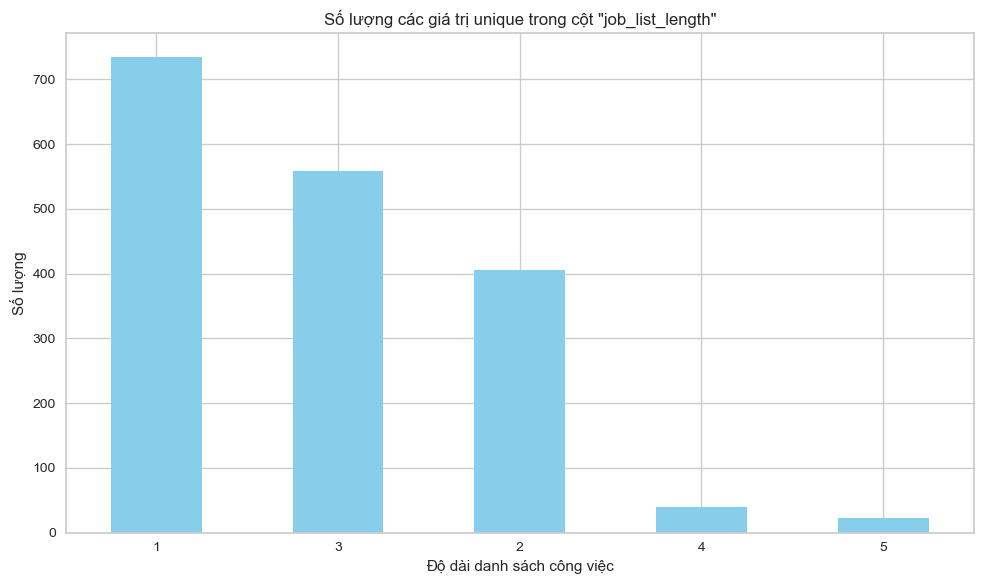

In [26]:
plt.figure(figsize=(10, 6))
value_counts_dev.plot(kind='bar', color='skyblue')
plt.xlabel('Độ dài danh sách công việc')
plt.ylabel('Số lượng')
plt.title('Số lượng các giá trị unique trong cột "job_list_length"')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [27]:
job_counts_dev = {}

# Duyệt qua mỗi danh sách công việc và đếm số lượng từng công việc
for jobs in dev['job_list']:
    for job in jobs:
        if job in job_counts_dev:
            job_counts_dev[job] += 1
        else:
            job_counts_dev[job] = 1

sorted_job_counts_dev = dict(sorted(job_counts_dev.items(), key=lambda x: x[1], reverse=True))

# Hiển thị kết quả sắp xếp
for job, count in sorted_job_counts_dev.items():
    print(f"{job}: {count}")

CNTT - Phần mềm: 210
Tư vấn: 187
 Bán hàng / Kinh doanh: 185
 Dịch vụ khách hàng: 163
 Tiếp thị / Marketing: 144
 Tài chính / Đầu tư: 143
 Tư vấn: 117
Bán lẻ / Bán sỉ: 92
Nhân sự: 91
Kế toán / Kiểm toán: 86
Giáo dục / Đào tạo: 84
Hành chính / Thư ký: 76
 Kế toán / Kiểm toán: 73
Vận chuyển / Giao nhận / Kho vận: 67
 Sản xuất / Vận hành sản xuất: 62
Bảo hiểm: 62
 Quản lý chất lượng (QA/QC): 58
 Điện / Điện tử / Điện lạnh: 56
Xây dựng: 56
 CNTT - Phần cứng / Mạng: 56
Quản lý điều hành: 52
Mỹ thuật / Nghệ thuật / Thiết kế: 48
Quản lý chất lượng (QA/QC): 47
Ngân hàng: 43
Dịch vụ khách hàng: 40
Tiếp thị / Marketing: 40
 Thực phẩm & Đồ uống: 36
 Nội ngoại thất: 35
 Xuất nhập khẩu: 35
 Bất động sản: 35
Bất động sản: 35
 Quảng cáo / Đối ngoại / Truyền Thông: 34
Bảo trì / Sửa chữa: 34
Thu mua / Vật tư: 32
 Ngân hàng: 29
 Luật / Pháp lý: 28
Cơ khí / Ô tô / Tự động hóa: 28
 Quản lý điều hành: 27
 Cơ khí / Ô tô / Tự động hóa: 26
 Nhà hàng / Khách sạn: 26
 Dệt may / Da giày / Thời trang: 26
 Hành ch

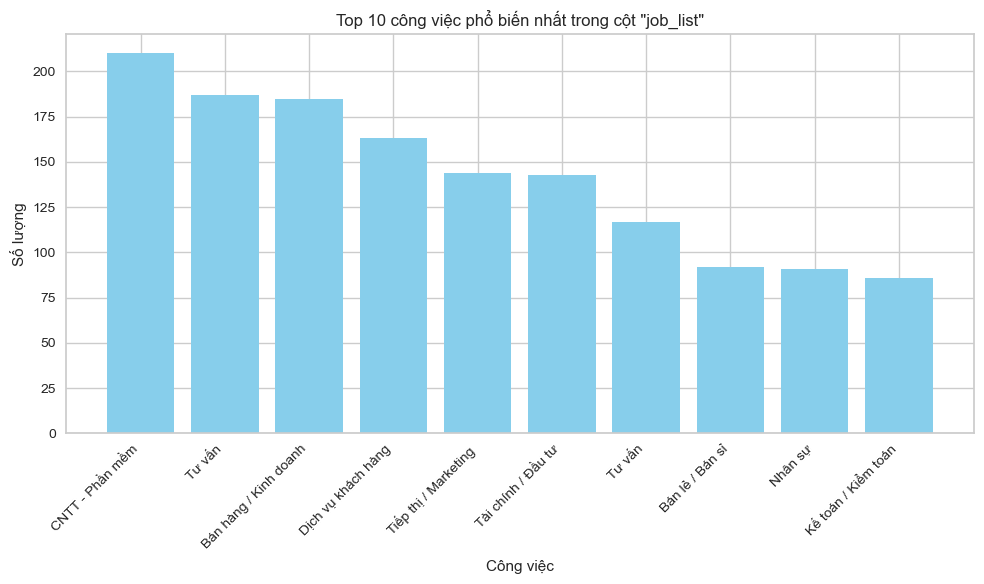

In [28]:
# Chuyển dictionary thành DataFrame để dễ xử lý và hiển thị
job_counts_df_dev = pd.DataFrame(list(job_counts_dev.items()), columns=['Job', 'Count'])

# Sắp xếp DataFrame theo số lượng giảm dần
job_counts_df_dev = job_counts_df_dev.sort_values(by='Count', ascending=False)

# Chọn ra top 10 công việc phổ biến nhất
top_10_jobs_dev = job_counts_df_dev.head(10)

# Trực quan hóa số lượng của top 10 công việc bằng biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(top_10_jobs_dev['Job'], top_10_jobs_dev['Count'], color='skyblue')
plt.xlabel('Công việc')
plt.ylabel('Số lượng')
plt.title('Top 10 công việc phổ biến nhất trong cột "job_list"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Split data

In [29]:
y_train = make_label(train)
y_dev = make_label(dev)
y_test = make_label(test)

X_train = train['job_description']
X_dev = dev['job_description']
X_test = test['job_description']

In [30]:
# Tiền xử lý dữ liệu
X_train, y_train = pre_process(X_train, y_train)
X_dev, y_dev = pre_process(X_dev, y_dev)
X_test, y_test = pre_process(X_test, y_test)

In [31]:
len(X_train)
# print(y_train.shape)
# print(X_dev.shape)
# print(y_dev.shape)
# print(X_test.shape)
# print(y_test.shape)


20234

In [32]:
# Tách từ cho tất cả các văn bản trong tập dữ liệu
all_texts = X_train + X_dev + X_test

# Tách từ cho tất cả các văn bản
tokenized_texts = [text.split() for text in all_texts]

In [33]:
# tokenized_texts[0]

In [34]:
# Huấn luyện mô hình Word2Vec
embedding_dim = 50  # Kích thước của embeddings - 100
word2vec_model = Word2Vec(tokenized_texts, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Lưu trữ embeddings
word_vectors = word2vec_model.wv

In [35]:
# Chuyển đổi văn bản thành chuỗi số dựa trên từ điển Word2Vec
def text_to_sequence(text, word_vectors):
    return [word_vectors.key_to_index[word] if word in word_vectors else 0 for word in text.split()]

# Chuyển đổi các văn bản trong tập train, dev và test
train_sequences = [text_to_sequence(text, word_vectors) for text in X_train]
dev_sequences = [text_to_sequence(text, word_vectors) for text in X_dev]
test_sequences = [text_to_sequence(text, word_vectors) for text in X_test]


In [36]:
# Đệm các chuỗi để tất cả đều có độ dài như nhau
maxlen = 100
X_train = pad_sequences(train_sequences, maxlen=maxlen)
X_dev = pad_sequences(dev_sequences, maxlen=maxlen)
X_test = pad_sequences(test_sequences, maxlen=maxlen)


## Visual 

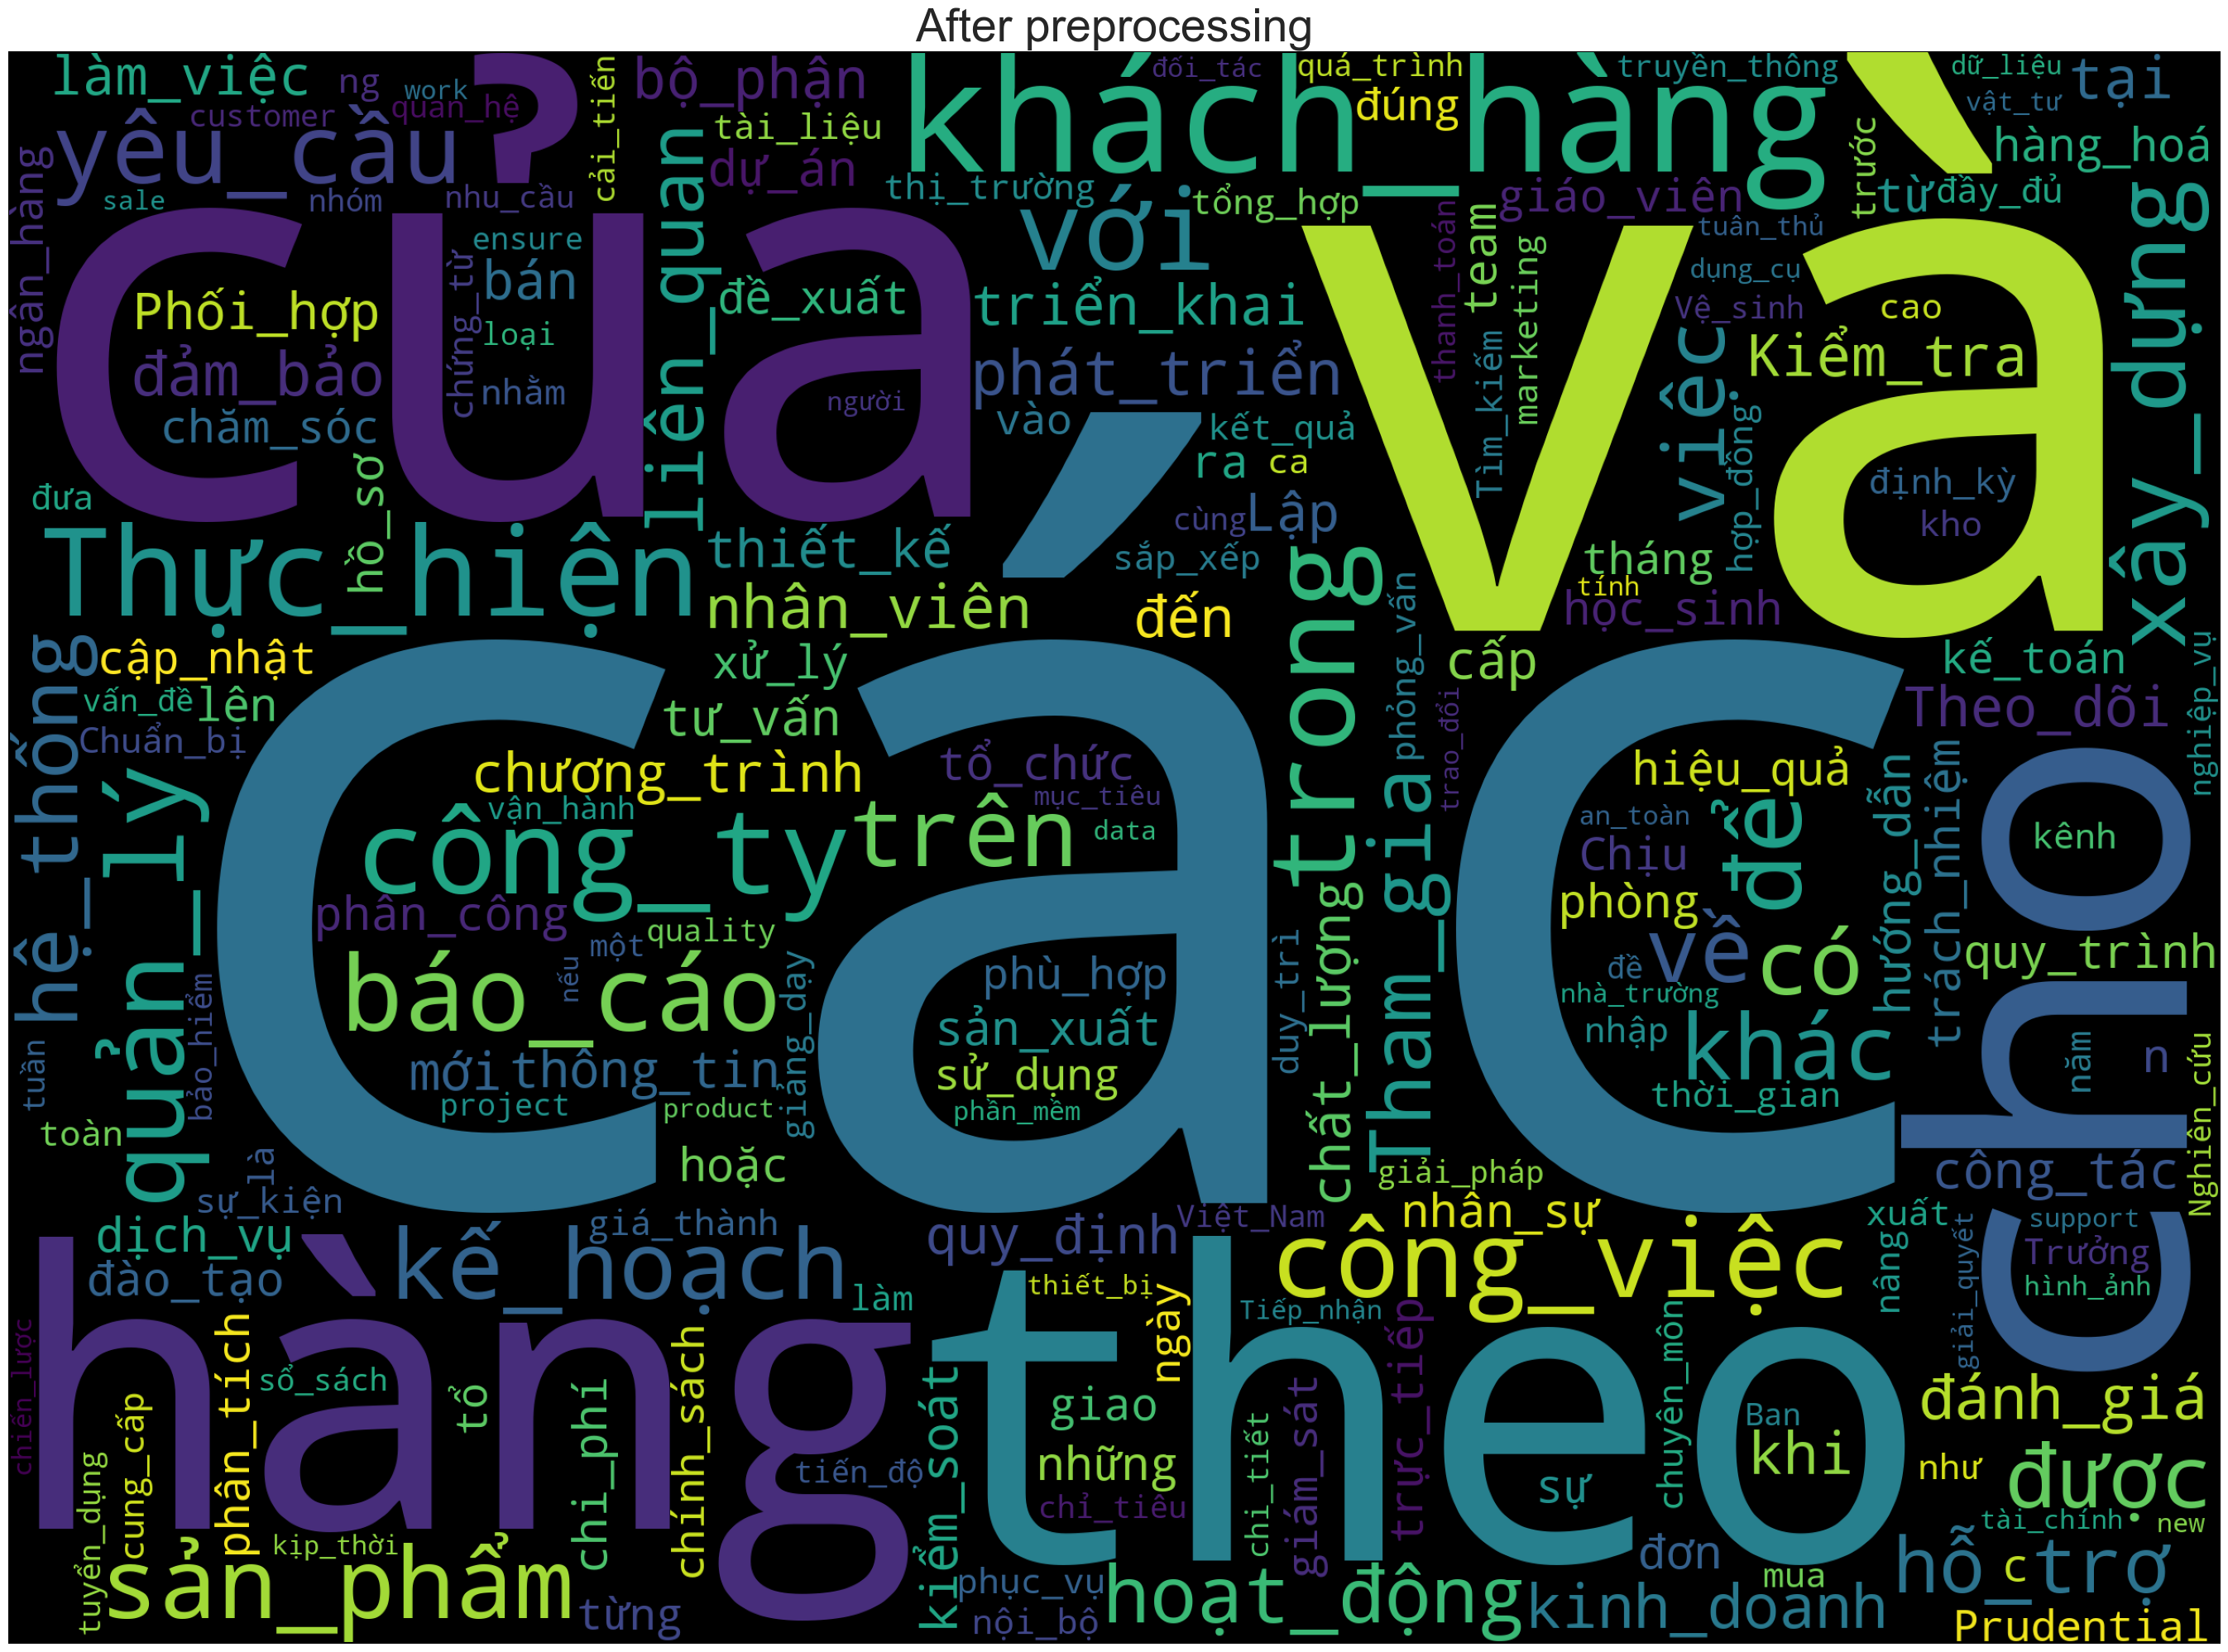

In [37]:
plt.figure(figsize=(40,25))
# clean

text = all_texts
cloud_comp = WordCloud(
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("After preprocessing",fontsize=40)
plt.imshow(cloud_comp)

### Preprocessing

### Train and test

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

In [39]:
job_types

array(['An Ninh / Bảo Vệ', 'An toàn lao động', 'Biên phiên dịch',
       'Bán hàng / Kinh doanh', 'Bán lẻ / Bán sỉ', 'Bưu chính viễn thông',
       'Bảo hiểm', 'Bảo trì / Sửa chữa', 'Bất động sản',
       'CNTT - Phần cứng / Mạng', 'CNTT - Phần mềm', 'Chăn nuôi / Thú y',
       'Chứng khoán', 'Công nghệ sinh học',
       'Công nghệ thực phẩm / Dinh dưỡng', 'Cơ khí / Ô tô / Tự động hóa',
       'Du lịch', 'Dược phẩm', 'Dầu khí',
       'Dệt may / Da giày / Thời trang', 'Dịch vụ khách hàng',
       'Giáo dục / Đào tạo', 'Giải trí',
       'Hàng gia dụng / Chăm sóc cá nhân', 'Hàng hải', 'Hàng không',
       'Hành chính / Thư ký', 'Hóa học', 'In ấn / Xuất bản', 'Khoáng sản',
       'Kiến trúc', 'Kế toán / Kiểm toán', 'Lao động phổ thông',
       'Luật / Pháp lý', 'Lâm Nghiệp', 'Môi trường',
       'Mới tốt nghiệp / Thực tập', 'Mỹ thuật / Nghệ thuật / Thiết kế',
       'Ngành khác', 'Ngân hàng', 'Nhà hàng / Khách sạn', 'Nhân sự',
       'Nông nghiệp', 'Nội ngoại thất', 'Phi chính phủ / Phi 

In [40]:
# # Using pipeline for applying logistic regression and one vs rest classifier
# LogReg_pipeline = Pipeline([
#                 ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
#             ])

# total_accuracy = 0

# for category in job_types:
#     print('**Processing {} comments...**'.format(category))
    
#     # Training logistic regression model on train data
#     LogReg_pipeline.fit(X_train, y_train)
    
#     # calculating test accuracy
#     prediction = LogReg_pipeline.predict(X_dev)
#     current_accuracy = accuracy_score(y_dev, prediction)
#     total_accuracy += current_accuracy
#     print('Test accuracy is {}'.format(current_accuracy))
#     print("\n")

## Technique to solve this problem:
- Problem Transformation: Binary Relevance, Classifier Chains, Label Powerset
- Adapted Algorithm
- Ensemble approaches
- Neural Network

In [41]:
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD

from joblib import dump, load

#### Reduce dimension


### Binary Relevance
- Classifier: GaussianNB

In [42]:
type(X_test)

numpy.ndarray

In [43]:
Accuracy_BR = []

In [44]:
X_train.shape


(20234, 100)

In [45]:
type(y_train)

list

In [55]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [46]:
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

In [47]:
print(y_train.shape)
print(y_test.shape)
print(y_dev.shape)

(20234, 68)
(3933, 68)
(1760, 68)


In [48]:
type(y_train[0])

numpy.ndarray

In [49]:
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(classifier = GaussianNB())
# train
classifier.fit(X_train, y_train)
# predict
predictions = classifier.predict(X_dev)
# accuracy
result_BR_NB = accuracy_score(y_dev,predictions)
Accuracy_BR.append(result_BR_NB)
print("Accuracy = ", result_BR_NB)

Accuracy =  0.0


- Classifier: SVM

In [50]:
y_train.shape

(20234, 68)

In [56]:
# # > 48m
# # initialize Binary Relevance multi-label classifier
# # with an SVM classifier
# # SVM in scikit only supports the X matrix in sparse representation

classifier = BinaryRelevance(
    classifier = SVC(),
    require_dense = [False, True]
)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_dev)

print("Accuracy = ",accuracy_score(y_dev,predictions))

ValueError: The number of classes has to be greater than one; got 1 class

In [52]:
# save the model
# dump(classifier, 'classifier_BR_SVM.joblib') 

['classifier_BR_SVM.joblib']

In [53]:
# classifier_BR_SVM = load('classifier_BR_SVM.joblib')
# predictions_BR_SVM = classifier_BR_SVM.predict(X_test_tfidf_reduced)

# result_BR_SVM = accuracy_score(y_test,predictions_BR_SVM)
# Accuracy_BR.append(result_BR_SVM)
# print("Accuracy = ", result_BR_SVM)

- Classifier: Logistic Regression

In [54]:
classifier_brlr = BinaryRelevance(classifier = LogisticRegression())

# train
classifier_brlr.fit(X_train, y_train)

# predict
predictions = classifier_brlr.predict(X_dev)

result_BR_LR = accuracy_score(y_dev,predictions)
Accuracy_BR.append(result_BR_LR)
print("Accuracy = ", result_BR_LR)

c:\Users\Snape\anaconda3\envs\torch\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Snape\anaconda3\envs\torch\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0

- Classifier: Random Forest

In [ ]:
# initialize BinaryRelevance multi-label classifier with a RandomForest
classifier = BinaryRelevance(
    classifier = RandomForestClassifier(n_estimators=100),
    require_dense = [False, True]
)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_dev)

result_BR_RF = accuracy_score(y_dev,predictions)
Accuracy_BR.append(result_BR_RF)
print("Accuracy = ", result_BR_RF) 

Accuracy =  0.5363341598321572


In [ ]:
# save the model
dump(classifier, 'classifier_BR_RF.joblib') 

['classifier_BR_RF.joblib']

### Classifier Chain

- GaussianNB

In [ ]:
Accuracy_CC = []

In [ ]:
# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier = ClassifierChain(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_dev)

result_CC_NB = accuracy_score(y_dev,predictions)
Accuracy_CC.append(result_CC_NB)
print("Accuracy = ", result_CC_NB) 


Accuracy =  0.0


In [ ]:
# # initialize classifier chains multi-label classifier
# # with an SVM classifier
# # SVM in scikit only supports the X matrix in sparse representation

# classifier = ClassifierChain(
#     classifier = SVC(),
#     require_dense = [False, True]
# )

# # train
# classifier.fit(X_train, y_train)

# # predict
# predictions = classifier.predict(X_dev)

# result_CC_SVM = accuracy_score(y_dev,predictions)
# Accuracy_CC.append(result_CC_SVM)
# print("Accuracy = ", result_CC_SVM) 

In [ ]:
# save the model
# dump(classifier, 'classifier_CC_SVM.joblib') 

In [ ]:
# classifier_CC_SVM = load('classifier_CC_SVM.joblib')
# predictions_CC_SVM = classifier_CC_SVM.predict(X_test_tfidf_reduced)

# result_CC_SVM = accuracy_score(y_test,predictions_CC_SVM)
# Accuracy_CC.append(result_CC_SVM)
# print("Accuracy = ", result_CC_SVM)

Accuracy =  0.38413122258249094


In [ ]:
# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())
# Training logistic regression model on train data
classifier.fit(X_train, y_train)
# predict
predictions = classifier.predict(X_dev)

# accuracy
result_CC_LR = accuracy_score(y_dev,predictions)
Accuracy_CC.append(result_CC_LR)
print("Accuracy = ", result_CC_LR) 

Accuracy =  0.6658401678428381


In [ ]:
# initialize Classifier Chain multi-label classifier with a RandomForest
classifier = ClassifierChain(
    classifier = RandomForestClassifier(n_estimators=100),
    require_dense = [False, True]
)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_dev)

result_CC_RF = accuracy_score(y_dev,predictions)
Accuracy_CC.append(result_CC_RF)
print("Accuracy = ", result_CC_RF) 

Accuracy =  0.5681861529658593


In [ ]:
# save the model
dump(classifier, 'classifier_CC_RF.joblib') 

['classifier_CC_RF.joblib']

### Label Powerset
- GaussianNB

In [ ]:
Accuracy_LP = []

In [ ]:
# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_dev)

result_LP_NB = accuracy_score(y_dev,predictions)
Accuracy_LP.append(result_LP_NB)
print("Accuracy = ", result_LP_NB) 

Accuracy =  0.17386363636363636


- SVC

In [ ]:
# # initialize Label Powerset chains multi-label classifier
# # with an SVM classifier
# # SVM in scikit only supports the X matrix in sparse representation

# classifier = LabelPowerset(
#     classifier = SVC(),
#     require_dense = [False, True]
# )

# # train
# classifier.fit(X_train, y_train)

# # predict
# predictions = classifier.predict(X_dev)

# result_LP_SVM = accuracy_score(y_dev,predictions)
# Accuracy_LP.append(result_LP_SVM)
# print("Accuracy = ", result_LP_SVM) 

Accuracy =  0.6885370970818234


- Logisitic Regression

In [ ]:
# using Label Powerset
# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())
# train
classifier.fit(X_train, y_train)
# predict
predictions = classifier.predict(X_dev)
# accuracy
result_LP_LR = accuracy_score(y_dev,predictions)
Accuracy_LP.append(result_LP_LR)
print("Accuracy = ", result_LP_LR) 

c:\Users\Snape\anaconda3\envs\torch\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy =  0.6748045012397482


- Random Forest

In [ ]:
# initialize Label Powerset multi-label classifier with a RandomForest
classifier = LabelPowerset(
    classifier = RandomForestClassifier(n_estimators=100),
    require_dense = [False, True]
)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_dev)

result_LP_RF = accuracy_score(y_dev,predictions)
Accuracy_LP.append(result_LP_RF)
print("Accuracy = ", result_LP_RF) 

Accuracy =  0.6135800114438299


In [ ]:
# Navie Bayes, SVC , Logistic regression, Randomforest
print(Accuracy_BR) # Binary Relevance
print(Accuracy_CC) # Classifier Chains
print(Accuracy_LP) # Label Powerset

[0.23097463284379172, 0.6566851039481213, 0.633034522220103, 0.5363341598321572]
[0.3154682433721152, 0.38413122258249094, 0.6658401678428381, 0.5681861529658593]
[0.3971008964333397, 0.6885370970818234, 0.6748045012397482, 0.6135800114438299]


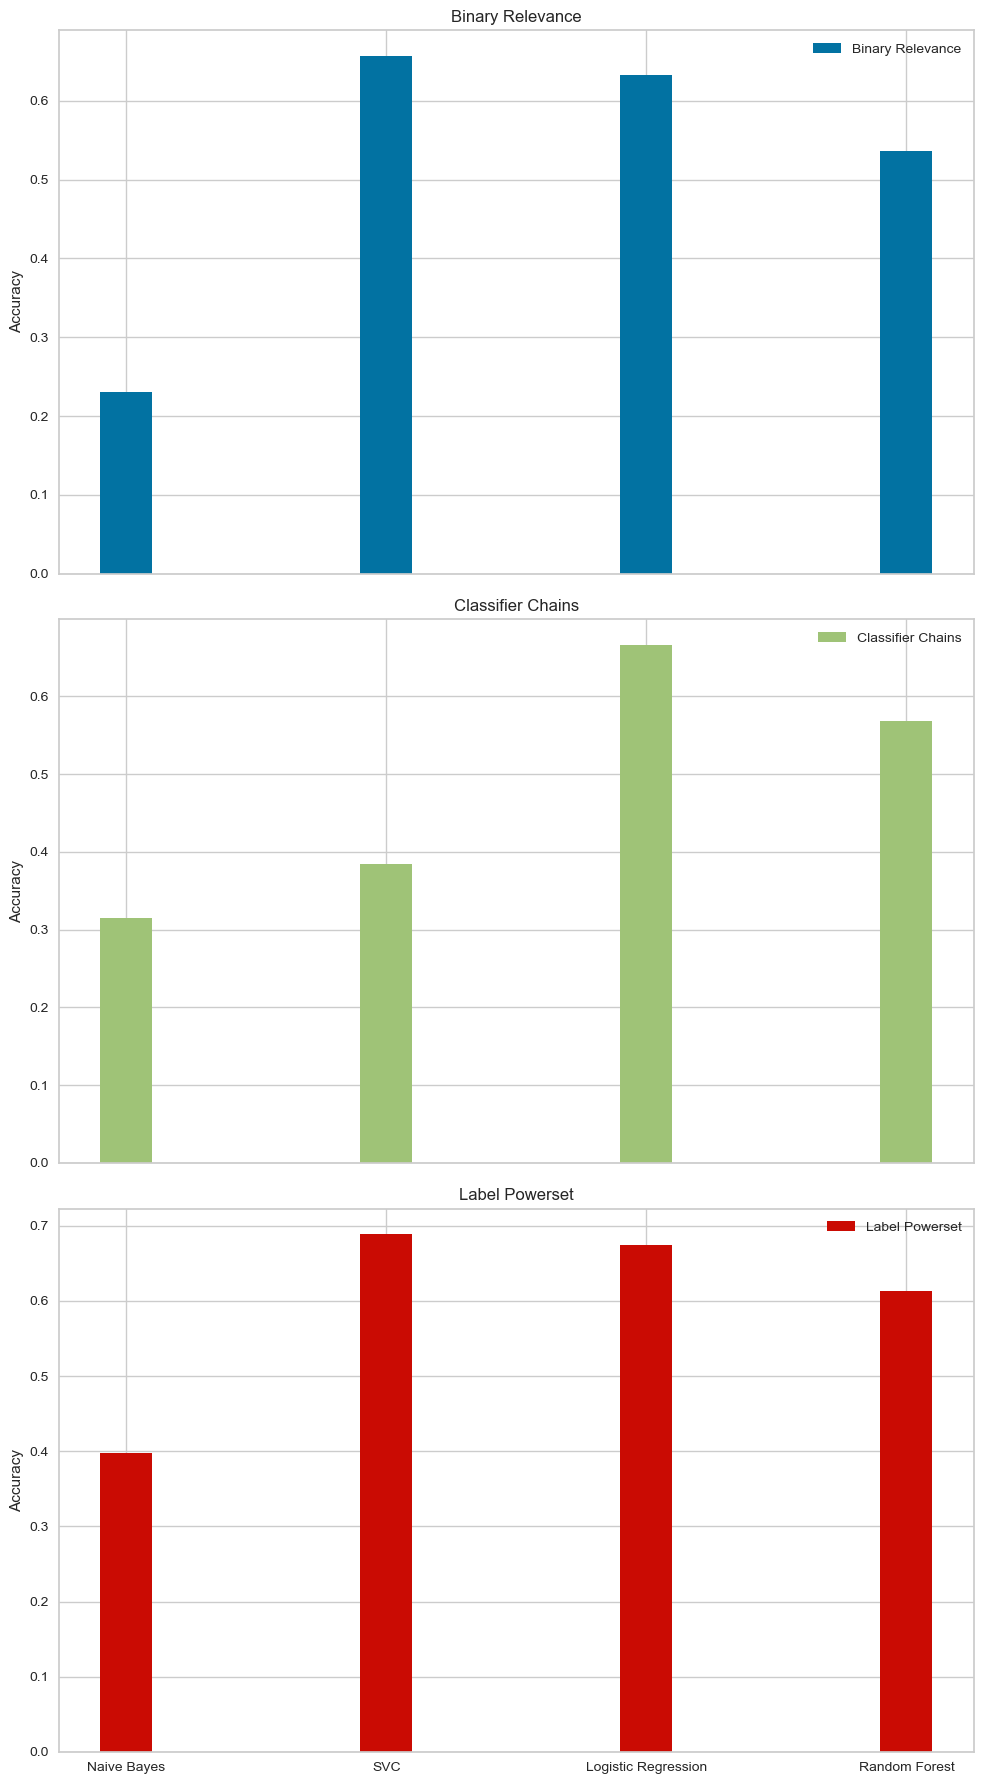

In [ ]:
# Labels for classifiers
classifiers = ['Naive Bayes', 'SVC', 'Logistic Regression', 'Random Forest']

# X-axis locations for the groups
x = np.arange(len(classifiers))

# Width of a bar 
width = 0.2

# Plotting with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

# Binary Relevance
axs[0].bar(x, Accuracy_BR, width, label='Binary Relevance', color='b')
axs[0].set_title('Binary Relevance')
axs[0].set_xticks(x)
axs[0].set_xticklabels(classifiers)
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Classifier Chains
axs[1].bar(x, Accuracy_CC, width, label='Classifier Chains', color='g')
axs[1].set_title('Classifier Chains')
axs[1].set_xticks(x)
axs[1].set_xticklabels(classifiers)
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Label Powerset
axs[2].bar(x, Accuracy_LP, width, label='Label Powerset', color='r')
axs[2].set_title('Label Powerset')
axs[2].set_xticks(x)
axs[2].set_xticklabels(classifiers)
axs[2].set_ylabel('Accuracy')
axs[2].legend()

# Adding legends
for ax in axs:
    ax.legend()

plt.tight_layout()
plt.show()


### Adaptive approach: MLKNN

In [ ]:
from skmultilearn.adapt import MLkNN
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix
from scipy import sparse
import numpy as np
from sklearn.metrics import accuracy_score, hamming_loss

In [ ]:
class PatchedMLkNN(MLkNN):
    def _compute_cond(self, X, y):
        """Helper function to compute the posterior probabilities"""
        
        # Initialize the NearestNeighbors model with the number of neighbors (self.k)
        self.knn_ = NearestNeighbors(n_neighbors=self.k).fit(X)
        
        # Initialize sparse matrices to count label co-occurrences
        # c[i, j] will store the count of label i co-occurring with j positive neighbors
        c = sparse.lil_matrix((self._num_labels, self.k + 1), dtype='i8')
        
        # cn[i, j] will store the count of label i co-occurring with j negative neighbors
        cn = sparse.lil_matrix((self._num_labels, self.k + 1), dtype='i8')

        # Convert y to a dense array if it's in sparse format
        y_dense = y.toarray() if sparse.issparse(y) else y

        # Loop over each label to compute conditional probabilities
        for i in range(self._num_labels):
            # Get the indices of instances with label i present (positive) and absent (negative)
            positive_indices = np.where(y_dense[:, i] == 1)[0]
            negative_indices = np.where(y_dense[:, i] == 0)[0]
            
            # If there are positive instances, compute the k-nearest neighbors for them
            if len(positive_indices) > 0:
                distances, indices = self.knn_.kneighbors(X[positive_indices], n_neighbors=self.k, return_distance=True)
                
                # For each set of neighbors, count how many of them have label i
                for neighbor_set in indices:
                    neighbor_count = np.sum(y_dense[neighbor_set], axis=0)
                    c[i, neighbor_count[i]] += 1

            # If there are negative instances, compute the k-nearest neighbors for them
            if len(negative_indices) > 0:
                distances, indices = self.knn_.kneighbors(X[negative_indices], n_neighbors=self.k, return_distance=True)
                
                # For each set of neighbors, count how many of them have label i
                for neighbor_set in indices:
                    neighbor_count = np.sum(y_dense[neighbor_set], axis=0)
                    cn[i, neighbor_count[i]] += 1

        # Return the counts of co-occurrences for positive and negative instances
        return c, cn


In [ ]:

# Use the patched class
classifier_new = PatchedMLkNN()
# Convert sparse matrices to dense arrays
x_train = lil_matrix(X_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(X_dev).toarray()
# Train
classifier_new.fit(x_train, y_train)
# Predict
predictions_new = classifier_new.predict(x_test)
# Accuracy
print("Accuracy = ", accuracy_score(y_dev, predictions_new))

Accuracy =  0.35685676139614725


In [ ]:
classifier = PatchedMLkNN(k=20)

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

print("Accuracy = ",accuracy_score(y_test,predictions_new))

Accuracy =  0.35685676139614725


## LSTM

In [ ]:
!nvidia-smi

Thu May 23 17:57:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P0             12W /   80W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
X_train

2132     Partial and Total Dielectronic Recombination R...
9243     The Multiple Roots Phenomenon in Maximum Likel...
13444    Control Variates for Stochastic Gradient MCMC....
15347    Time pressure and honesty in a deception game....
18566    Time-Sensitive Networking for robotics.   We a...
                               ...                        
11284    Tensor Methods for Nonlinear Matrix Completion...
11964    Numerical Simulations of Collisional Cascades ...
5390     Possible evidence for spin-transfer torque ind...
860      Common Knowledge in a Logic of Gossips.   Goss...
15795    Trust-Based Collaborative Filtering: Tackling ...
Name: CONTEXT, Length: 15729, dtype: object

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
y_test


,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
20257,1,0,0,0,0,0
482,0,0,1,1,0,0
4189,1,0,1,0,0,0
9838,0,1,0,1,0,0
16591,1,0,0,0,0,0
...,...,...,...,...,...,...
10827,0,1,0,0,0,0
4304,0,0,1,0,0,0
10747,1,0,0,1,0,0
8382,1,0,0,0,0,0


In [ ]:
max_words = len(set(" ".join(X_train).split()))
max_len = X_train.apply(lambda x: len(x)).max()

In [ ]:
# hyperparameters
MAX_LEN = 256
BATCH_SIZE = 32
EMBEDDING_DIM = 100
EPOCHS = 2
LEARNING_RATE = 1e-05

In [ ]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=max_len)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)


In [ ]:

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Convert targets to float tensors
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)   

In [ ]:
y_train.shape[1]

6

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.texts[index], dtype=torch.long),
            'targets': self.targets[index]
        }

train_dataset = CustomDataset(X_train_pad, y_train)
test_dataset = CustomDataset(X_test_pad, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
class TextClassificationLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(TextClassificationLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = x[:, -1, :]  # Take the output of the last LSTM cell
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

VOCAB_SIZE = min(max_len, len(tokenizer.word_index) + 1)
EMBED_SIZE = EMBEDDING_DIM
HIDDEN_SIZE = 100
OUTPUT_SIZE = y_train.shape[1]  # Number of classes

model = TextClassificationLSTM(VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
model.to(device)


c:\Users\Snape\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


TextClassificationLSTM(
  (embedding): Embedding(2862, 100)
  (lstm): LSTM(100, 100, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=100, out_features=6, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Training Loop
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0
    epoch_train_loss = 0

    for batch in train_loader:
        inputs = batch['input_ids'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == targets).sum().item()
        total += targets.size(0) * targets.size(1)

    train_acc.append(correct / total)
    train_loss.append(epoch_train_loss / len(train_loader))

    model.eval()
    correct = 0
    total = 0
    epoch_val_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == targets).sum().item()
            total += targets.size(0) * targets.size(1)

    val_acc.append(correct / total)
    val_loss.append(epoch_val_loss / len(test_loader))

    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}')



Epoch 1/25, Train Loss: 0.0408, Val Loss: 0.3875, Train Acc: 0.9862, Val Acc: 0.9057
Epoch 2/25, Train Loss: 0.0342, Val Loss: 0.4052, Train Acc: 0.9891, Val Acc: 0.9044
Epoch 3/25, Train Loss: 0.0295, Val Loss: 0.4246, Train Acc: 0.9907, Val Acc: 0.9063
Epoch 4/25, Train Loss: 0.0259, Val Loss: 0.4414, Train Acc: 0.9919, Val Acc: 0.9040
Epoch 5/25, Train Loss: 0.0265, Val Loss: 0.4386, Train Acc: 0.9915, Val Acc: 0.9055
Epoch 6/25, Train Loss: 0.0252, Val Loss: 0.4587, Train Acc: 0.9921, Val Acc: 0.9037
Epoch 7/25, Train Loss: 0.0218, Val Loss: 0.4652, Train Acc: 0.9935, Val Acc: 0.9064
Epoch 8/25, Train Loss: 0.0210, Val Loss: 0.4804, Train Acc: 0.9934, Val Acc: 0.9040
Epoch 9/25, Train Loss: 0.0220, Val Loss: 0.5062, Train Acc: 0.9930, Val Acc: 0.9057
Epoch 10/25, Train Loss: 0.0223, Val Loss: 0.4776, Train Acc: 0.9929, Val Acc: 0.9026
Epoch 11/25, Train Loss: 0.0231, Val Loss: 0.5041, Train Acc: 0.9928, Val Acc: 0.9038
Epoch 12/25, Train Loss: 0.0151, Val Loss: 0.5199, Train Acc: 0

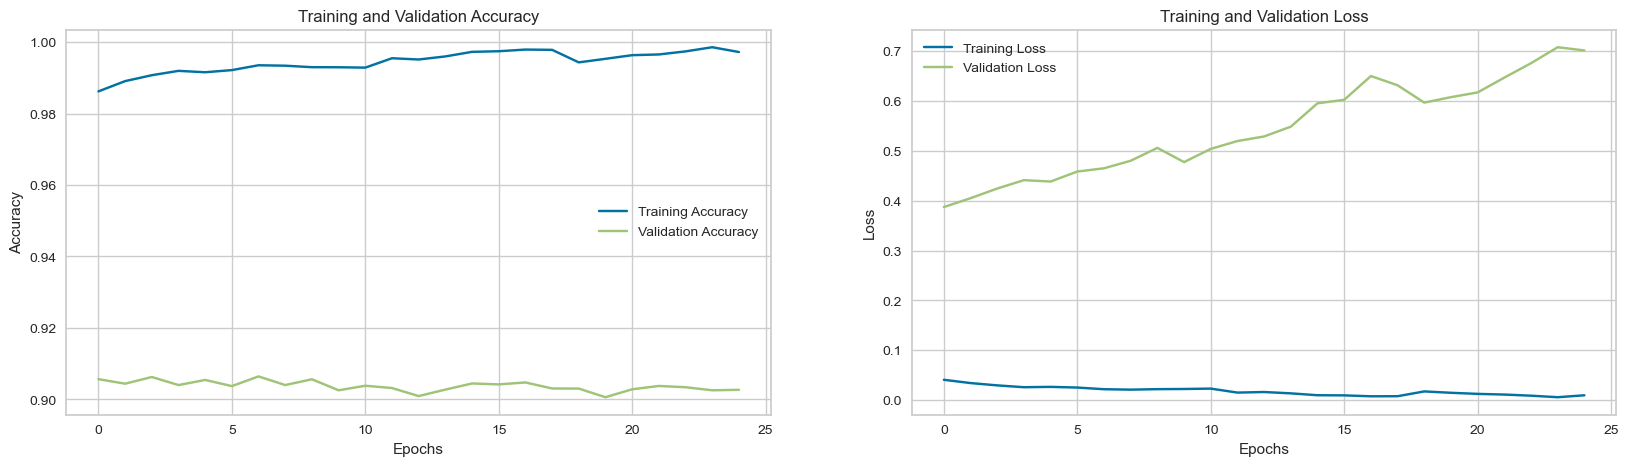

In [ ]:
# Plotting
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()